In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from nasbench import api
from random_search import run_random_search, random_spec

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
sns.set_theme(style="whitegrid", font_scale=2.25)

## NASBench-101

### Preprocessing NASBench-101

In [4]:
if not os.path.exists('nasbench_only108.tfrecord'):
    !curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_only108.tfrecord')

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 42 seconds


In [5]:
full_metrics = nasbench.computed_statistics

### Oracle: An Upper Bound Baseline

In [6]:
# Each model (point) is the validation accuracy from a single training run. Test accuracies are averaged over three runs. 
accuracies = []

for _, model in tqdm(full_metrics.items()):
    metrics = model[108]
    metric = random.choice(metrics)
    val_acc = metric['final_validation_accuracy']
    test_acc = np.average([metric['final_test_accuracy'] for metric in metrics])
    
    accuracies.append([val_acc, test_acc])
accuracies = np.array(accuracies)

  0%|          | 0/423624 [00:00<?, ?it/s]

Validation vs. Test accuracy plot (Fig. 3)

In [7]:
percent_acc = pd.DataFrame(accuracies * 100, columns=['validation', 'test'])

/home/patara/anaconda3/envs/patara/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


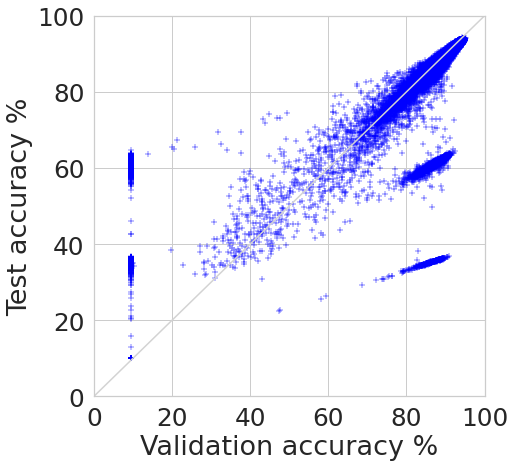

In [8]:
f, ax = plt.subplots(figsize=(7, 7))
g = sns.scatterplot(data=percent_acc, x='validation', y='test', color='#0000FF', ax=ax, marker='+')
g.plot([0, 1], [0, 1], transform=ax.transAxes, color='lightgray')
g.set(xlabel='Validation accuracy %', ylabel='Test accuracy %', xlim=[0, 100], ylim=[0, 100])
f.savefig('figures/fig3a.pdf', dpi=96, format='pdf', bbox_inches='tight')

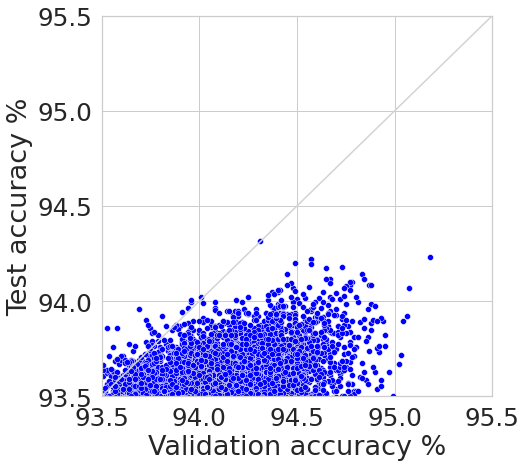

In [9]:
high_acc = percent_acc[percent_acc['validation'] >= 93.5].reset_index(drop=True)

f, ax = plt.subplots(figsize=(7, 7))
g = sns.scatterplot(data=high_acc, x='validation', y='test', color='#0000FF', ax=ax)
g.plot([0, 1], [0, 1], transform=ax.transAxes, color='lightgray')
g.set(xlabel='Validation accuracy %', ylabel='Test accuracy %', xlim=[93.5, 95.5], ylim=[93.5, 95.5])
f.savefig('figures/fig3b.pdf', dpi=96, format='pdf', bbox_inches='tight')

In [10]:
# oracle_val, oracle_test = percent_acc['validation'].max(), percent_acc['test'].max()
print(f"Best Validation Accuracy: {percent_acc['validation'].max()}")
print(f"Best Test Accuracy: {percent_acc['test'].max()}")

Best Validation Accuracy: 95.18229365348816
Best Test Accuracy: 94.3175752957662


In [11]:
# Averaged over 100 oracle experiments, where in each experiment we randomly select one of 3 validation results, 
# Variance Test for Oracle
oracle_val_acc = []
oracle_test_acc = []

# Repeat oracle method for 100 times
for _ in tqdm(range(100)):
    val_acc = []
    test_acc = []
    
    for _, model in full_metrics.items():
        metrics = model[108]
        metric = random.choice(metrics)
        val_acc.append(metric['final_validation_accuracy'])
        test_acc.append(metric['final_test_accuracy'])
    
    oracle_val_acc.append(np.max(val_acc))
    oracle_test_acc.append(np.max(test_acc))

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
oracle_val_acc, oracle_val_std = np.average(oracle_val_acc) * 100, np.std(oracle_val_acc) * 100
print("Oracle Validation Accuracy")
print(f"avg: {oracle_val_acc} std: {oracle_val_std}")

oracle_test_acc, oracle_test_std = np.average(oracle_test_acc) * 100, np.std(oracle_test_acc) * 100
print("Oracle Test Accuracy")
print(f"avg: {oracle_test_acc} std: {oracle_test_std}")

Oracle Validation Accuracy
avg: 95.14312928915024 std: 0.0352447052017722
Oracle Test Accuracy
avg: 94.55608928203583 std: 0.0793029424782464


### Random Search: A Lower Bound Baseline

In [17]:
# Change the experiment setting here
# 600 runs, max 5000 samples, time limit set to 8e6 according to the paper

LOOPS = 600
MAX_SAMPLES = 5000
MAX_TIME_BUDGET = 8e6

In [19]:
random_val_avg, random_test_avg = [], []
random_val_std, random_test_std = [], []

val_acc, test_acc = [], []
for _ in tqdm(range(MAX_SAMPLES)):
    loop_val, loop_test = [], []
    for _ in range(LOOPS):
        metric = nasbench.query(random_spec(nasbench))
        loop_val.append(metric['validation_accuracy'])
        loop_test.append(metric['test_accuracy'])

    val_acc.append(np.mean(loop_val))
    test_acc.append(np.mean(loop_test))
    
    random_val_avg.append(np.max(val_acc))
    random_val_std.append(np.std(loop_val))
    
    random_test_avg.append(np.max(test_acc))
    random_test_std.append(np.std(loop_test))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
times = []
best_vals = []
best_tests = []

for _ in tqdm(range(LOOPS)):
    time, best_val, best_test = run_random_search(nasbench, max_time_budget=MAX_TIME_BUDGET)

    times.append(np.average(time))
    best_vals.append(np.average(best_val))
    best_tests.append(np.average(best_test))

avg_times = np.average(np.array(times), axis=0)
avg_best_vals = np.average(np.array(best_vals), axis=0)
avg_best_tests = np.average(np.array(best_tests), axis=0)

  0%|          | 0/600 [00:00<?, ?it/s]

### Neural Predictor: Two Stages

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Average
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from spektral.layers import GCNConv
from spektral.utils.convolution import gcn_filter

# training: N (train) + K (validation) models
budgets = 
N = 
K = budgets - N

# In each experiment, we use the validation accuracy from a single run1 as a search signal. 
# The single run is uniformly sampled from these three records. 
labels = 

def gcn_regressor(n_layers, n_filters):
    """
    **Input**
    - Node features of shape `([batch], n_nodes, n_node_features)`;
    - Modified Laplacian of shape `([batch], n_nodes, n_nodes)`; can be computed with
    `spektral.utils.convolution.gcn_filter`.
    """
    
    n_channels = 
    graphs = 
    A =
    AT = np.transpose()
    
    node_input = Input()
    
    for l in range(n_layers):
        V1 = GCNConv(n_channels, activation='relu')(, A)
        V2 = GCNConv(n_channels, activation='relu')(, AT)
        V = Average()([V1, V2])
    
    y = Dense()(V)
        
    
    return model

### Neural Predictor: Single Stage